[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Abade_and_Albuquerque_2024/fig_2.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Abade_and_Albuquerque_2024/fig_2.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Abade_and_Albuquerque_2024/fig_2.ipynb)

#### based on Fig. 2 from [Abade & Albuquerque 2024 (QJRMS)](https://doi.org/10.1002/qj.4775)  "_Persistent mixed‐phase states in adiabatic cloud parcels under idealised conditions_"

compared to the paper, the analysis below differs by:
- including only the "Homogeneous" and "Bulk" methods (no "stochastic" yet)
- extending the analysis to cover both singular (INAS, as used in the paper) as well as time-dependent (ABIFM) immersion freezing models
- extending the analysis to depict multiple realisations + mean
- extending the analysis to illustrate the dependence of realisation spread on the number of super droplets used
- extending the analysis to depict how the results differ depending on the vertical velocity (cooling rate)



In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import os
import numpy as np
from matplotlib import pyplot
from scipy.interpolate import interp1d
from open_atmos_jupyter_utils import show_plot
from PySDM import Formulae
from PySDM.physics import si, in_unit
from PySDM.backends import CPU
from PySDM_examples.utils.widgets import display, FloatProgress
from PySDM_examples.Arabas_et_al_2025.commons import FREEZING_CONSTANTS
from PySDM_examples.Abade_and_Albuquerque_2024 import Simulation, Settings

In [3]:
backend = CPU(
    formulae = Formulae(
        constants={
            "bulk_phase_partitioning_exponent": 0.1,
            **FREEZING_CONSTANTS["dust"],
        },
        bulk_phase_partitioning="KaulEtAl2015",
        particle_shape_and_density="MixedPhaseSpheres",
        diffusion_coordinate="WaterMassLogarithm",
        freezing_temperature_spectrum="Niemand_et_al_2012",
        heterogeneous_ice_nucleation_rate="ABIFM",
    ),
    override_jit_flags={"parallel": False}
)

In [4]:
CI = 'CI' in os.environ
n_realisations = 3 if not CI else 1
n_sds = (128, 512, 2048) if not CI else (64,) # PAPER: "on the order of 1e6"
updrafts = (3.6, 1.2, .4) if not CI else (3.6,.4) # PAPER: 0.5 m/s

dz_out = 100 * si.s
timestep = 1 * si.s
z_max = 4 * si.km
display(progbar := FloatProgress(value=1, max=(1 + 2 * n_realisations * len(n_sds)) * len(updrafts)))


settings_commons_part = {
    'enable_immersion_freezing': True,
    'enable_vapour_deposition_on_ice': True,
}

datasets = {}
for updraft in updrafts:
    t_max = z_max / updraft
    settings_commons = {
        'updraft': updraft,
        'timestep': timestep,
        'backend': backend,
        'inp_frac': .5, # PAPER: .1
    }
    run_args = {
        'nt': int(t_max / timestep),
        'steps_per_output_interval': int(dz_out / updraft / timestep),
    }
    progbar.description = f'Bulk-{updraft}'
    datasets[f'Bulk-{updraft}'] = {'realisations': [Simulation(Settings(
        **settings_commons,
        n_sd=1,
        enable_immersion_freezing=False,
        enable_vapour_deposition_on_ice=False,
    )).run(**run_args)]}
    progbar.value += 1
    for singular, label in {True: 'INAS', False: 'ABIFM'}.items():
        for n_sd in n_sds:
            datasets[(key := f'Homogeneous-{label}-{n_sd}-{updraft}')] = {'realisations': []}
            backend.formulae.seed = 0
            for i in range(n_realisations):
                progbar.description = '...' + key[-3:] + f'-{i}-{updraft}'
                datasets[key]['realisations'].append(
                    Simulation(Settings(
                        **settings_commons,
                        **settings_commons_part,
                        n_sd=n_sd,
                        singular=singular
                    )).run(**run_args)
                )
                backend.formulae.seed += 1
                progbar.value += 1

FloatProgress(value=1.0, max=57.0)

In [60]:
colors = {
    'ice+water': 'black',
    'ice': 'cyan',
    'water': 'blue',
    'vapour': 'gray',
    'total': 'orange',
}

def plot_setup(ax):
    ax.set_xlabel(r"r (g$\cdot$kg$^{-1}$)")
    ax.set_ylabel('Height (km)')
    ax.set_ylim(.75, 3)
    ax.set_xlim(-.05, 1.75)
    ax.grid()
    
def plot_part(ax, data):    
    for realisation in data['realisations']:
        realisation['ice+water'] = np.asarray(realisation['water']) + np.asarray(realisation['ice'])
        realisation['vapour'] = np.asarray(realisation['vapour'])
        realisation['total'] = np.asarray(realisation['ice+water']) + np.asarray(realisation['vapour'])

    data['mean'] = {}
    for name in ('ice', 'water', 'ice+water', 'height', 'vapour', 'total'):
        data['mean'][name] = [
            np.mean([realisation[name][level] for realisation in data['realisations']]) 
            for level in range(len(data['realisations'][0][name]))
        ]
    
    for name in ('ice', 'water', 'ice+water', 'vapour', 'total'):
        for realisation in data['realisations']:
            ax.plot(
                in_unit(np.asarray(realisation[name]), si.g / si.kg),
                in_unit(np.asarray(realisation['height']), si.km),
                linestyle='--' if name == 'ice+water' else '-',
                color=colors[name],
                linewidth=.75,
            )
        mean = data['mean']
        ax.plot(
            in_unit(np.asarray(mean[name]), si.g / si.kg),
            in_unit(np.asarray(mean['height']), si.km),
            label=name,
            marker='.',
            color=colors[name],
        )

def plot_bulk(ax, data):
    liquid_fraction = backend.formulae.bulk_phase_partitioning.liquid_fraction(np.asarray(data['T']))
    total_condensed_mixing_ratio = np.asarray(data['water'])
    vapour_mixing_ratio = np.asarray(data['vapour'])
    for name in ('ice', 'water', 'ice+water', 'vapour', 'total'):
        values = {
            'ice+water': total_condensed_mixing_ratio,
            'ice': (1 - liquid_fraction) * total_condensed_mixing_ratio,
            'water': liquid_fraction * total_condensed_mixing_ratio,
            'vapour': vapour_mixing_ratio,
            'total': vapour_mixing_ratio + total_condensed_mixing_ratio,
        }[name]
        ax.plot(
            in_unit(values, si.g / si.kg),
            in_unit(np.asarray(data['height']), si.km),
            label=name,
            marker='.',
            color=colors[name],
            linestyle='--' if name == 'ice+water' else '-'
        )
    interp_temp = interp1d(
        in_unit(np.asarray(data['height']), si.km),
        backend.formulae.trivia.K2C(np.asarray(data['T'])),
        bounds_error=True
    )        
    ax2 = ax.twinx()
    ax2.set_yticks(ax.get_yticks(), [f"{t:.1f}" for t in interp_temp(ax.get_yticks())])
    ax2.set_ylim(ax.get_ylim())        
    ax2.set_ylabel('Temperature [°C]')
    ax.legend(
        loc='lower center',
        bbox_to_anchor=(0.5, -.65),
        fancybox=True,
        shadow=True,
        ncol=1
    )

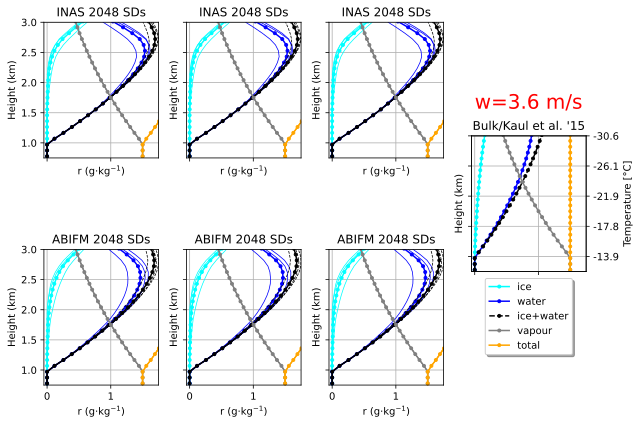

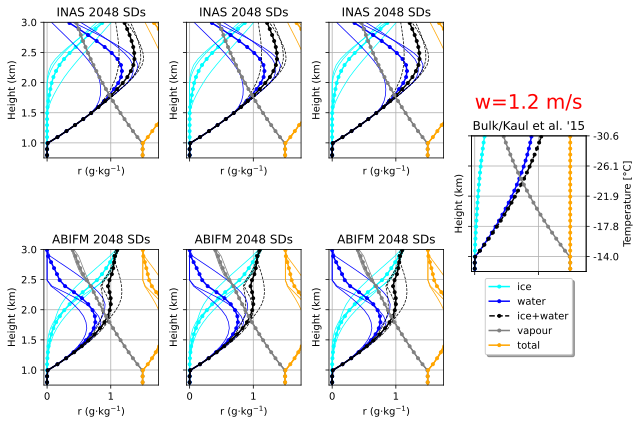

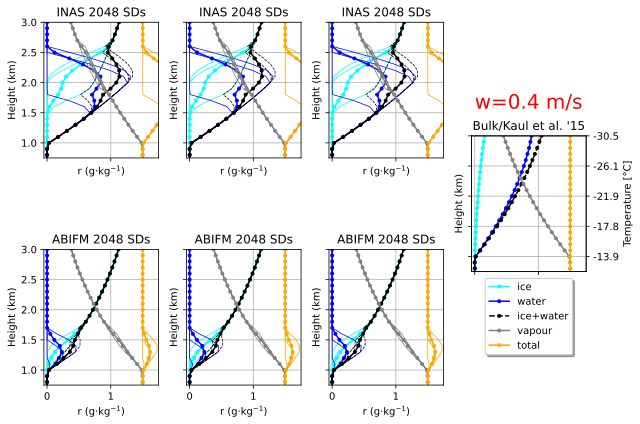

In [61]:
for updraft in updrafts:
    fig, axs = pyplot.subplot_mosaic(
        """ABC.
           ABCG
           DEFG
           DEF.
        """,
        figsize=(9, 6),
        sharex=True,
        sharey=True,
        tight_layout=False,
    )
    for ax in axs.values():
        plot_setup(ax)
    
    for label, model, index in (
        ("A", "INAS", 0),
        ("B", "INAS", 1),
        ("C", "INAS", 2),
        ("D", "ABIFM", 0),
        ("E", "ABIFM", 1),
        ("F", "ABIFM", 2),
    ):
        if index + 1 > len(n_sds):
            continue
        axs[label].set_title(f"{model} {n_sd} SDs")
        plot_part(axs[label], datasets[f'Homogeneous-{model}-{n_sd}-{updraft}'])
    
    axs["G"].set_title("Bulk/Kaul et al. '15")
    plot_bulk(axs["G"], datasets[f'Bulk-{updraft}']['realisations'][0])
    axs["G"].text(x=0, y=3.45, s=f"w={updraft} m/s", color='red', size=20)
    show_plot(f'fig_2-updraft={updraft}.pdf')